# Wellcome Data Cleansing Project

This is a data-cleaning exercise for my thinkful Data Science Course
Raj Prasad, May 2019

## Tasks: 
* determine the five most common journals 
* determine the total articles for each of the above. 
* calculate the mean, median, and standard deviation of the open-access cost per article for each journal.
* (bonus) identify the open access prices paid by subject area.

(You will need to do considerable data cleaning in order to extract accurate estimates. You may may want to look into data encoding methods if you get stuck.)


## Import & Clean the Data

* I converted the given file to unicode 8 by opening it in Apple's Numbers application and saving it as unicode 8 (feels like cheating, but it worked.)
* I cleaned the cost column - removing '£' and punctution and converting to numeric
* I used ngrams, tfidf and cosine similarity to normalize the journal names

The last of these was more involved.  I followed the process defined [here](https://bergvca.github.io/2017/10/14/super-fast-string-matching.html) by Chris van den Berg.   

In [1]:
#imports, file load, and print header of raw data

#note that I converted the file to unicode8 with another utility

import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import seaborn as sns
%matplotlib inline

#import data from local file - assumed to be in same directory as this workbook
w = pd.read_csv('WELLCOME_APCspend2013_forThinkful2.csv')


In [2]:
#a look at the starting table
w.head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04
2,23043264 PMC3506128,ACS,J Med Chem,"Fumaroylamino-4,5-epoxymorphinans and related ...",£642.56
3,23438330 PMC3646402,ACS,J Med Chem,Orvinols with mixed kappa/mu opioid receptor a...,£669.64
4,23438216 PMC3601604,ACS,J Org Chem,Regioselective opening of myo-inositol orthoes...,£685.88


number of costs >100k is  49


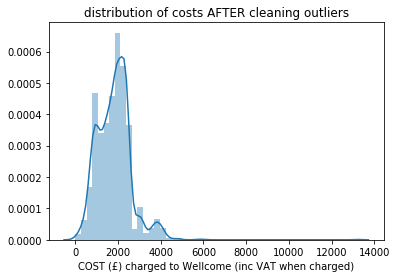

In [3]:
#clean the cost column

#check to make sure the "£" is in every cell...there is
#commented as the check is complete and need not be re-executed
# lbs_rows = [("£" in x) for x in w["COST (£) charged to Wellcome (inc VAT when charged)"]]
# print(len(lbs_rows)) 

#check to make sure the "." is in every cell...there is
#commented as the check is complete and need not be re-executed
# period_rows = [("." in x) for x in w["COST (£) charged to Wellcome (inc VAT when charged)"]]
# print(len(period_rows))

def clean_money(df, col):
    if isinstance(df[col][0], str): 
        df[col] = pd.to_numeric(
            df[col].str.strip('£').str.strip('$').str.replace(",", "")) 

clean_money(w, "COST (£) charged to Wellcome (inc VAT when charged)")

#clean up outlier costs - mostly '999999'
num_outliers = len(w[w["COST (£) charged to Wellcome (inc VAT when charged)"]>=100000])
print("number of costs >100k is ", num_outliers)

w = w[w["COST (£) charged to Wellcome (inc VAT when charged)"] < 100000]

sns.distplot(w["COST (£) charged to Wellcome (inc VAT when charged)"])
plt.title("distribution of costs AFTER cleaning outliers")
plt.show()


In [4]:
#Clean the journal title column
#There are around ~1k journal names, and many are likely mis / alternate spellings of the
#same journal name.  So I'm going to use TfId and cosine similarity normalize the names. 

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from sparse_dot_topn import awesome_cossim_topn

def ngrams(string, n=3):
    string = re.sub(r'[,-./]|',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

def get_matches_df(sparse_matrix, name_vector, top=100):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similarity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similarity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similarity})

w["Journal title"] = [str(i).lower() for i in (w["Journal title"])]
#create a list of unique journal names
journals = [str(i) for i in (w["Journal title"].sort_values().unique())]

#get the TfIdf matrix
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(journals)

#get the most similar matches - I iterated and 80% seems to be a good cut-off
#for finding different names that are really the same journal
matches = awesome_cossim_topn(tf_idf_matrix, tf_idf_matrix.transpose(), 10, 0.80)
matches_df = get_matches_df(matches, journals, top=False)
matches_df = matches_df[matches_df['similarity'] < .99999999999999] # Remove all exact matches

#convert the matches table into a dictionary
s = set()
for index, row in matches_df.iterrows(): 
    s.add(tuple(set([row["left_side"], row["right_side"]])))

title_dict=dict()
title_dict = dict(s)

#create a new column with normalized journal titles
normalized_titles = []
for index, row in w.iterrows():
    curr_title = row["Journal title"]
    normalized_titles.append(title_dict.get(curr_title, curr_title))
w["Normalized Journal Title"] = normalized_titles


In [5]:
#Sample of cleaned data (only showing a few rows with cleaned titles)
w[w["Journal title"] != w["Normalized Journal Title"]].head()

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged),Normalized Journal Title
16,22610094,AMBSB,journal of biological chemistry,Annexin-1 interaction with FPR2/ALX,265.67,the journal of biological chemistry
31,PMID:23281892 PMC3579312,American Chemical Society,journal of medicinal chemistry,A class of 5-nitro-2-furancarboxylamides with ...,321.12,journal of medicinal chemistry
33,PMC3593610,American Chemical Society,journal of the american chemical society,Chemical and structural analysis of an antibod...,1626.14,american chemical society
42,"23576705, PMC3727040",American Physiological Society,the journal of neurophysiology,Integration of Texture and Disparity Cue to Su...,1276.60,journal of neurophysiology
43,NaN,American Psychiatric Association,american journal of psychiatry,Methamphetamine-induced disruption of frontost...,2351.73,americal journal of psychiatry


## Tasks

In [6]:
# Task 1: determine the five most common journals
w['Normalized Journal Title'].value_counts().head(5).index.to_list()

['plos one',
 'the journal of biological chemistry',
 'neuroimage',
 'nucleic acid research',
 'proceedings of the national academy of sciences']

In [7]:
# Task 2: get count of articles for top 5 journals (showing 6 as tie for 5th)
w['Normalized Journal Title'].value_counts().head(6)

plos one                                           182
the journal of biological chemistry                 52
neuroimage                                          29
nucleic acid research                               26
proceedings of the national academy of sciences     23
plos pathogens                                      22
Name: Normalized Journal Title, dtype: int64

In [8]:
# Task 3: calculate the mean, median, and sd per article cost 
# (showing just top 6 journals by article count)

#df.sort_values(by=('Labs', 'II'), ascending=False)
summ_by_journal = w.groupby("Normalized Journal Title").describe().reset_index().sort_values(by=("COST (£) charged to Wellcome (inc VAT when charged)", "count"), ascending=False)

#summ_by_journal = w.groupby("Normalized Journal Title").describe().reset_index().sort_values(by="Normalized Journal Title", ascending=False)

summ_by_journal.head(6)


Normalized Journal Title  \
                                                       
669                                         plos one   
758              the journal of biological chemistry   
607                                       neuroimage   
628                            nucleic acid research   
682  proceedings of the national academy of sciences   
665                                    plos genetics   

    COST (£) charged to Wellcome (inc VAT when charged)               \
                                                  count         mean   
669                                              182.0    934.655824   
758                                               52.0   1423.588462   
607                                               29.0   2215.168276   
628                                               26.0   1181.769231   
682                                               23.0    794.667826   
665                                               22.0   1643.110909   

                                                                   
            std      min        25%       50%        75%      max  
669  201.847589   122.31   850.1250   896.975  1040.7375  1785.36  
758  411.954360   265.67  1152.1900  1301.140  1609.8225  2501.07  
607  266.653947  1747.16  2100.5400  2326.430  2396.5700  2503.34  
628  451.521987   710.00   852.0000   852.000  1704.0000  2184.00  
682  453.665104   206.32   639.1900   751.840   789.4900  2691.68  
665  153.366825  1394.05  1465.7475  1712.730  1770.1950  1809.51

In [9]:
#bonus task - average cost by topic area

from sklearn.cluster import KMeans

#use k-means to cluster the journal titles
num_clusters = 50 #k=50 seemed to give good semantic separation
km = KMeans(n_clusters=num_clusters)
%time km.fit(tf_idf_matrix)
clusters = km.labels_.tolist()

#add the cluster label to the dataset
cluster_dict = dict(zip(journals, clusters))
cluster_assignments = []
for index, row in w.iterrows():
    curr_title = row["Journal title"]
    cluster_assignments.append(cluster_dict.get(curr_title))
w["cluster"] = cluster_assignments

CPU times: user 6.86 s, sys: 537 ms, total: 7.4 s
Wall time: 3.77 s


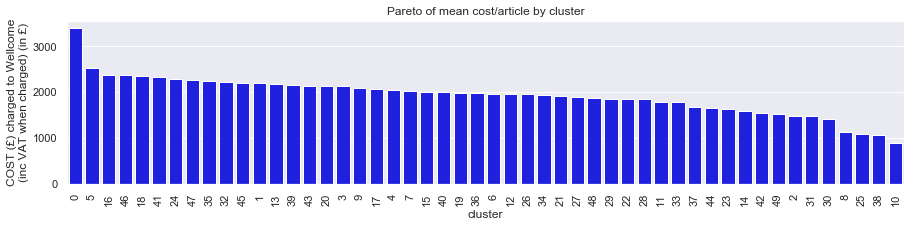

In [10]:
#get the average cost/article by cluster
cluster_costs = w[["COST (£) charged to Wellcome (inc VAT when charged)",
                  "cluster"]].groupby("cluster").mean().reset_index().\
                    sort_values(by="COST (£) charged to Wellcome (inc VAT when charged)", ascending=False)

sns.set()
plt.figure(figsize=(15, 3))
sns.barplot(x="cluster", y="COST (£) charged to Wellcome (inc VAT when charged)", data=cluster_costs, color="blue", order=cluster_costs.index)
plt.xticks(rotation=90)
plt.title("Pareto of mean cost/article by cluster")
plt.ylabel("COST (£) charged to Wellcome\n(inc VAT when charged) (in £)")
plt.show()

In [16]:
#the lancet (prevalent in cluster 0) seems to be expensive...
w[w.cluster == 0]


,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged),Normalized Journal Title,cluster
318,23698510 PMC3812900,BMJ Group,sex transm infect.,Cross-sectional survey of treatment practices ...,1700.00,sex transm infect.,0
648,NaN,Elsevier,lancet,Global trends in antiretroviral resistance in ...,4800.00,lancet,0
649,PMID:23545320,Elsevier,lancet global health,Stroke risk factors within an incident populat...,3678.78,lancet global health,0
796,PMC3525981,Elsevier,the lancet,Dementia incidence and mortality in middle inc...,4320.00,the lancet,0
797,NaN,Elsevier,the lancet,The impact on a serogroup a meningococcal conj...,4554.01,the lancet,0
798,PMCID:\n PMC3627205,Elsevier,the lancet,Effects of unconditional and conditional cash ...,4800.00,the lancet,0
799,NaN,Elsevier,the lancet neurology,MRI investigation of the sensorimotor cortex a...,4320.00,the lancet neurology,0
800,PMID: 23041239 /PMCID: PMC3490334,Elsevier,the lancet neurology,Genetic risk factors for ischaemic stroke and ...,5760.00,the lancet neurology,0
834,3507620,Elsevier,lancet,Managing Severe infection in infancy in resour...,838.35,lancet,0
835,3771416,Elsevier,lancet infect dis,"Efficacy of RTS,S malaria vaccines: individual...",3600.00,lancet infect dis,0


In [15]:
#journals with "frontiers" in the name (cluster 10) seem to be cheap...
w[w.cluster == 10]

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged),Normalized Journal Title,cluster
870,PMC3677134,Frontiers,frontiers in brain imaging methods,"Quantitative multiparameter mapping of R1, PD*...",1087.97,frontiers in brain imaging methods,10
874,NaN,Frontiers,frontiers in cognitive science,"Exploration, Novelty, Surprise and Free Energy...",434.70,frontiers in cognitive science,10
877,NaN,Frontiers,frontiers in electrophysiology,Bridging the gap between computation and clini...,827.13,frontiers in electrophysiology,10
879,PMC3735983,Frontiers,frontiers in genetics,The mysterious case of the C. elegans gut gran...,346.25,frontiers in genetics,10
884,PMC3502006,Frontiers,frontiers in immunological memory,CD161+CD4+ T cells are enriched in teh liver d...,775.82,frontiers in immunological memory,10
885,PMC3444764,Frontiers,frontiers in inflammation,NLRP3-inflammasome activating DAMPs stimulate ...,687.79,frontiers in inflammation,10
886,PMC3564010,Frontiers,frontiers in invertebrate physiology,Exposure to acetylcholinesterase inhibitors al...,967.18,frontiers in invertebrate physiology,10
888,PMC3676342,Frontiers,frontiers in schizophrenia,The computational anatomy of psychosis,821.98,frontiers in schizophrenia,10
891,PMCID: PMC3557415,Frontiers Media,frontiers in perception science,Attribution of intentional causation influence...,987.91,frontiers in perception science,10
892,PMC3521128,Frontiers Media SA,frontiers in brain imaging methods,Measuring abnormal brains: building normative ...,476.57,frontiers in brain imaging methods,10
